In [1]:
!pip install transformers


In [2]:
!pip install --upgrade transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 97.1 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.45.1
    Uninstalling transformers-4.45.1:
      Successfully uninstalled transformers-4.45.1


In [3]:
!pip install tensorflow==2.9.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 99.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 101.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 46.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting uninstall:

In [ ]:
# Instalar dependencias en Colab
#!pip install tensorflow vit-keras openpyxl

# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
#from vit_keras import vit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import MinMaxScaler
from transformers import ViTModel, ViTFeatureExtractor
from PIL import Image
import os

In [51]:

# Parámetros de imagen
rows, cols, channels = 96, 96, 1  # Redimensionar imágenes a cuadrado para ViT 95 95 1
image_size = 95  # Tamaño de imagen en ViT
output_feature = "biomasa"  # Columna objetivo
patch_size = 16  # Tamaño del parche (ViT)

In [52]:
# Ruta a los datos
data_path = '/kaggle/input/data-dias/Datos_dias.xlsx'  # Carga tu archivo Excel en Colab
image_dir = '/kaggle/input/fotos-dias/Datos_dias'  # Carpeta con imágenes de entrenamiento


In [53]:
# Cargar datos
data = pd.read_excel(data_path)
input_features = ['Irradiancia', 'NO3', 'TEMP', 'pH', 'CO2 Gas']  # Ajusta según tus columnas
target_feature = 'biomasa'


In [54]:

scaler = MinMaxScaler()
data[input_features] = scaler.fit_transform(data[input_features])
data[target_feature] = scaler.fit_transform(data[[target_feature]])

In [55]:
# Cargar imágenes y redimensionar para ViT
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB").resize((image_size, image_size))
    return np.array(img) / 255.0

all_images = [
    preprocess_image(os.path.join(image_dir, img_name))
    for img_name in sorted(os.listdir(image_dir))
]
all_images = np.array(all_images)

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [58]:
from sklearn.model_selection import KFold

# Parámetros de K-Fold
k = 3  # Número de folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Variables para guardar métricas
r2_scores, mse_scores, rmse_scores, mae_scores, mape_scores = [], [], [], [], []

for train_index, test_index in kf.split(all_images):
    # Dividir los datos en train y test para este fold
    img_train, img_test = all_images[train_index], all_images[test_index]
    y_train, y_test = data[target_feature].values[train_index], data[target_feature].values[test_index]
    
    # Construir el modelo (reinicia el modelo en cada fold)
    inp = Input(shape=(image_size, image_size, 3))
    x = Flatten()(inp)  # Simulación de salida de ViT
    x = Dense(32, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(256, activation="tanh")(x)
    output = Dense(1, activation="linear")(x)  # Output lineal

    model_vit = Model(inputs=inp, outputs=output)
    model_vit.compile(optimizer=Adam(learning_rate=1e-4), loss="mse", metrics=["mae", "mse"])
    
    # Entrenamiento con EarlyStopping
    early_stop = EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    model_vit.fit(
        img_train, y_train,
        validation_data=(img_test, y_test),
        epochs=500,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Predicción y evaluación en el fold actual
    y_pred = model_vit.predict(img_test).flatten()
    r2_scores.append(r2_score(y_test, y_pred))
    mse_scores.append(mean_squared_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    mape_scores.append(mean_absolute_percentage_error(y_test, y_pred))

# Promediar métricas finales
metrics = {
    "R2": np.mean(r2_scores),
    "MSE": np.mean(mse_scores),
    "RMSE": np.mean(rmse_scores),
    "MAE": np.mean(mae_scores),
    "MAPE": np.mean(mape_scores),
}

print(metrics)


Epoch 1/500
1/1 [==============================] - 1s 540ms/step - loss: 0.3301 - mae: 0.4929 - mse: 0.3301 - val_loss: 0.1287 - val_mae: 0.3080 - val_mse: 0.1287
Epoch 2/500
1/1 [==============================] - 0s 26ms/step - loss: 0.1515 - mae: 0.3531 - mse: 0.1515 - val_loss: 0.1121 - val_mae: 0.2792 - val_mse: 0.1121
Epoch 3/500
1/1 [==============================] - 0s 25ms/step - loss: 0.1201 - mae: 0.2763 - mse: 0.1201 - val_loss: 0.0562 - val_mae: 0.2104 - val_mse: 0.0562
Epoch 4/500
1/1 [==============================] - 0s 25ms/step - loss: 0.0538 - mae: 0.1995 - mse: 0.0538 - val_loss: 0.0405 - val_mae: 0.1516 - val_mse: 0.0405
Epoch 5/500
1/1 [==============================] - 0s 25ms/step - loss: 0.0412 - mae: 0.1537 - mse: 0.0412 - val_loss: 0.0259 - val_mae: 0.1293 - val_mse: 0.0259
Epoch 6/500
1/1 [==============================] - 0s 25ms/step - loss: 0.0245 - mae: 0.1147 - mse: 0.0245 - val_loss: 0.0245 - val_mae: 0.1399 - val_mse: 0.0245
Epoch 7/500
1/1 [==========

In [56]:
# División de datos
img_train, img_test, y_train, y_test = train_test_split(all_images, data[target_feature].values, test_size=0.3, random_state=42)

# Cargar modelo preentrenado de ViT
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224")
# Construcción del modelo
inp = Input(shape=(image_size, image_size, 3))
x = Flatten()(inp)  # Simulación de salida de ViT para fine-tuning
x = Dense(32, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(128, activation="relu")(x)

x = Dense(256, activation="relu")(x)
x = Dense(256, activation="tanh")(x)
output = Dense(1, activation="linear")(x) #linear

model_vit = Model(inputs=inp, outputs=output)
model_vit.compile(optimizer=Adam(learning_rate=1e-4), loss="mse", metrics=["mae", "mse"])

# Entrenamiento
early_stop = EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
history_vit = model_vit.fit(
    img_train, y_train,
    validation_data=(img_test, y_test),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Predicción y métricas
y_pred = model_vit.predict(img_test).flatten()
metrics = {
    "R2": r2_score(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred),
}

print(metrics)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/500
1/1 [==============================] - 1s 603ms/step - loss: 0.4139 - mae: 0.5514 - mse: 0.4139 - val_loss: 0.5717 - val_mae: 0.7245 - val_mse: 0.5717
Epoch 2/500
1/1 [==============================] - 0s 27ms/step - loss: 0.3678 - mae: 0.5138 - mse: 0.3678 - val_loss: 0.3634 - val_mae: 0.5614 - val_mse: 0.3634
Epoch 3/500
1/1 [==============================] - 0s 27ms/step - loss: 0.2252 - mae: 0.3885 - mse: 0.2252 - val_loss: 0.2298 - val_mae: 0.4186 - val_mse: 0.2298
Epoch 4/500
1/1 [==============================] - 0s 27ms/step - loss: 0.1580 - mae: 0.3525 - mse: 0.1580 - val_loss: 0.1169 - val_mae: 0.2939 - val_mse: 0.1169
Epoch 5/500
1/1 [==============================] - 0s 28ms/step - loss: 0.1136 - mae: 0.3020 - mse: 0.1136 - val_loss: 0.0557 - val_mae: 0.2194 - val_mse: 0.0557
Epoch 6/500
1/1 [==============================] - 0s 29ms/step - loss: 0.1167 - mae: 0.2844 - mse: 0.1167 - val_loss: 0.0427 - val_mae: 0.1850 - val_mse: 0.0427
Epoch 7/500
1/1 [==========

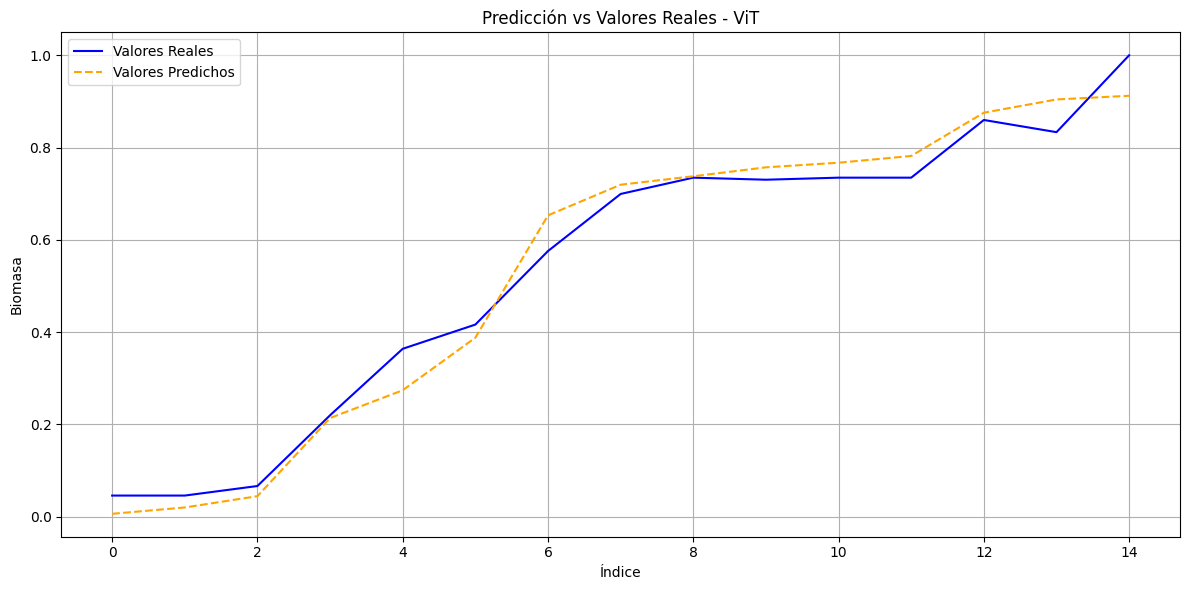

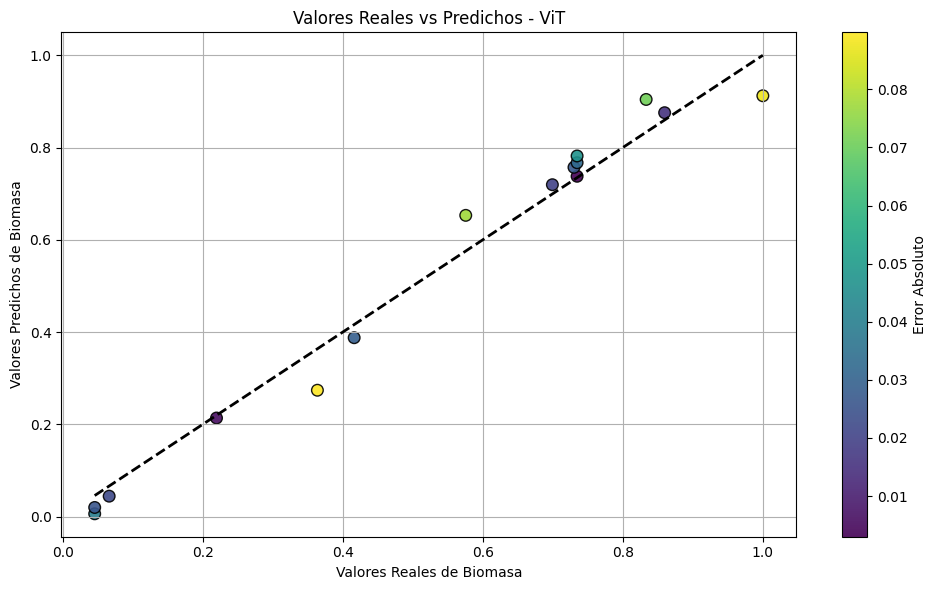

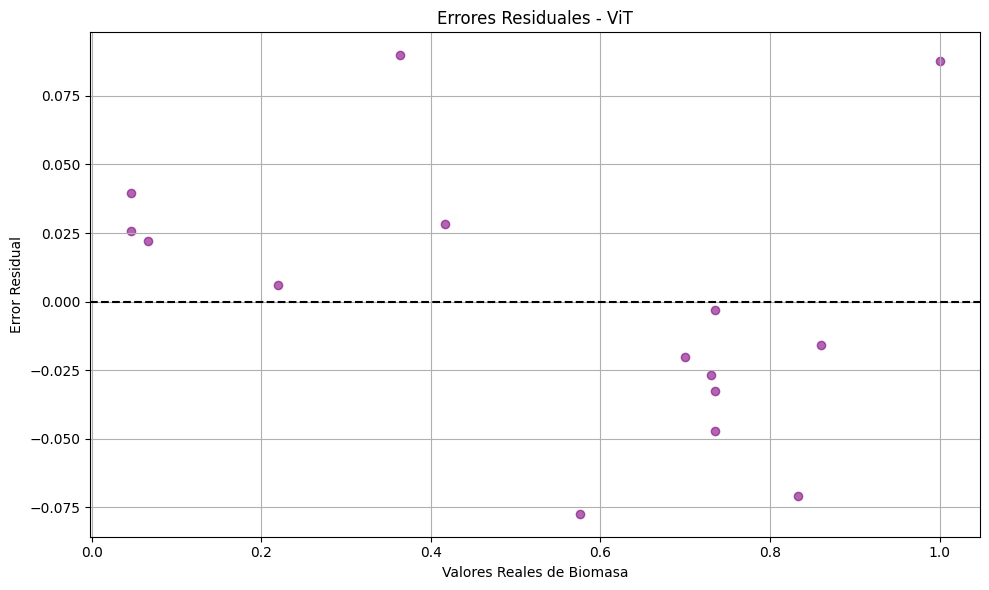

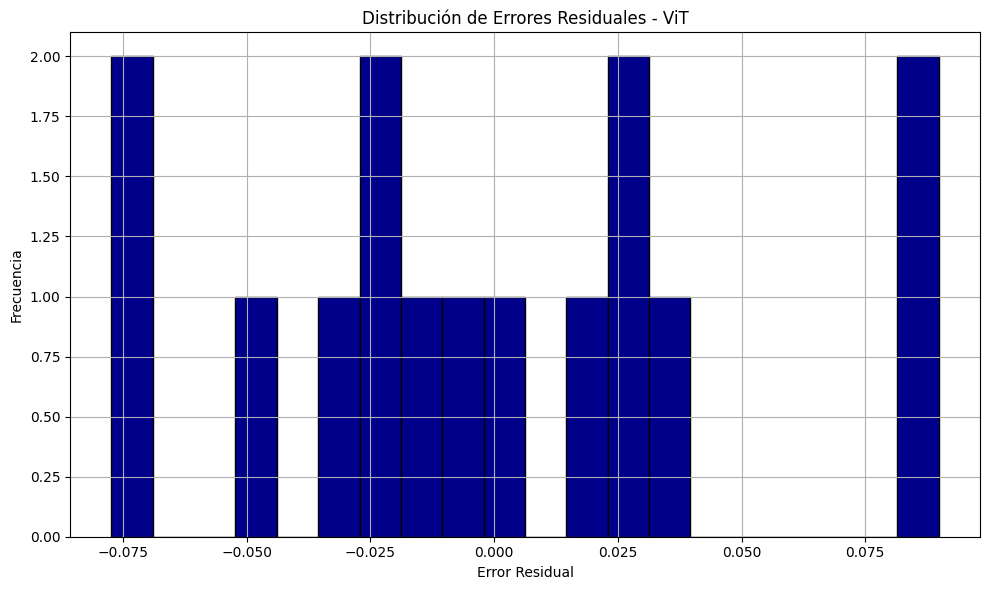

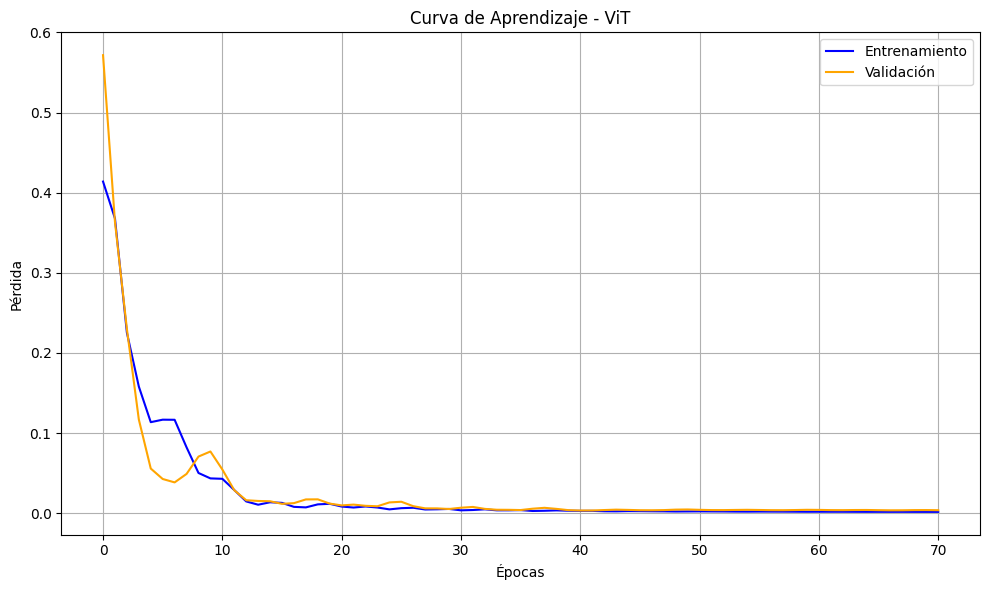

In [59]:

# Exportar métricas a Excel
#metrics_df = pd.DataFrame([metrics])
#metrics_df.to_excel("metrics_vit.xlsx", index=False)

# Visualización de resultados
# Gráfico 1: Predicciones vs Reales
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Valores Reales', color='blue')
plt.plot(y_pred, label='Valores Predichos', color='orange', linestyle='--')
plt.title('Predicción vs Valores Reales - ViT')
plt.xlabel('Índice')
plt.ylabel('Biomasa')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Gráfico 2: Dispersión de Predicciones vs Reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, c=np.abs(y_test - y_pred), cmap='viridis', s=70, alpha=0.9, edgecolor='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Valores Reales vs Predichos - ViT')
plt.xlabel('Valores Reales de Biomasa')
plt.ylabel('Valores Predichos de Biomasa')
plt.colorbar(label='Error Absoluto')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 3: Errores Residuales
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.6, color="purple")
plt.axhline(0, linestyle='--', color='black')
plt.title('Errores Residuales - ViT')
plt.xlabel('Valores Reales de Biomasa')
plt.ylabel('Error Residual')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 4: Histograma de Errores
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color="darkblue", edgecolor='black')
plt.title('Distribución de Errores Residuales - ViT')
plt.xlabel('Error Residual')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 5: Curva de Aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(history_vit.history['loss'], label='Entrenamiento', color='blue')
plt.plot(history_vit.history['val_loss'], label='Validación', color='orange')
plt.title('Curva de Aprendizaje - ViT')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Descargar el archivo Excel con las métricas
#from google.colab import files
#files.download("metrics_vit.xlsx")